In [2]:
# You don't need to run this--it's just a workaround so images show up in these Github Jupyter notebooks
from ngeegee.utils import display_image_gh_notebook
from IPython.display import HTML

## 3. Creating gridded ELM inputs
This notebook demonstrates how to sample raw ERA5-Land hourly meteorological data from Google Earth Engine using either points or polygons, then process the downloaded data for export to ELM-ready gridded netCDF files.

**Important**: "gridded" refers to the *netCDF* itself, not the domain we're sampling over. In other words, the netCDF files exported here now have a spatial component (i.e. embedded lat/lon) as opposed to the single-site exports demonstrated in Notebook `2`. Basically, in Notebook `2`, we exported each "grid cell" as its own site's met data. Here, we end up only exporting a single netCDF for each variable because we're not considering each cell/pixel to be an independent site.

While there are essentially still only two functions you must call to download and export ELM--ready data, because we're now exporting these data as gridded (or at least spatially-distributed) netCDF files, the inputs are slightly more complicated. Notebook `2` is what you want to use if you only need site netCDFs (it can do more than one site at a time, but the exporting is done per site.)
  
In this notebook, we will consider the watershed of the streamflow gage near the outlet of the Kuparuk River. Our goal will be to sample ERA5-Land hourly data at the native ERA5 resolution for all grid cells that intersect this watershed. It is OK not to have rectangular domains when providing ELM met data, as ELM searches for the nearest point in the netCDF to extract its met data. Therefore, you can have any sets of latitutdes and longitudes. That's what we'll do here to avoid fetching and reformatting ERA5-Land hourly data that we don't need. It mostly happens under the hood, anyway. :) 

Here is our target watershed, the Kuparuk.


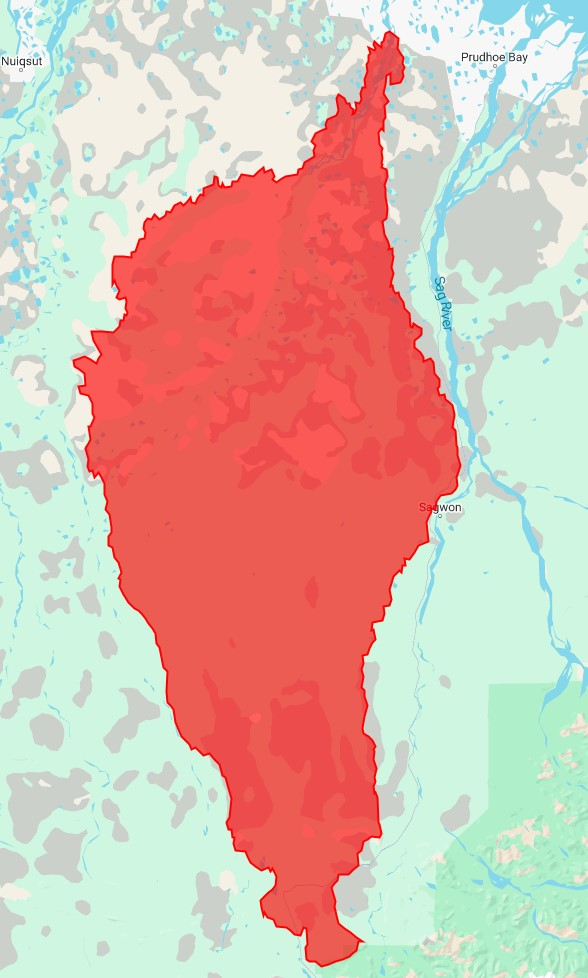

In [4]:
display(HTML(display_image_gh_notebook('3-kuparak.jpg')))

First, we want to find all of the ERA5-Land hourly pixels or cells that intersect our watershed. I've already done some preprocessing of the ERA5-Land hourly grid that we can use. I have made these GEE Assets public, so you can reference them in any of your GEE code. Here are their addresses; all of this is already in the code so this is just for reference:


- Center point of each ERA5-Land hourly cell: `https://code.earthengine.google.com/?asset=projects/ee-jonschwenk/assets/E3SM/e5lh_centerpoints`

- Polygons of each ERA5-Land hourly cell: `https://code.earthengine.google.com/?asset=projects/ee-jonschwenk/assets/E3SM/e5lh_grid`

Here's a plot of the ERA5-Land hourly grids and points for our watershed.


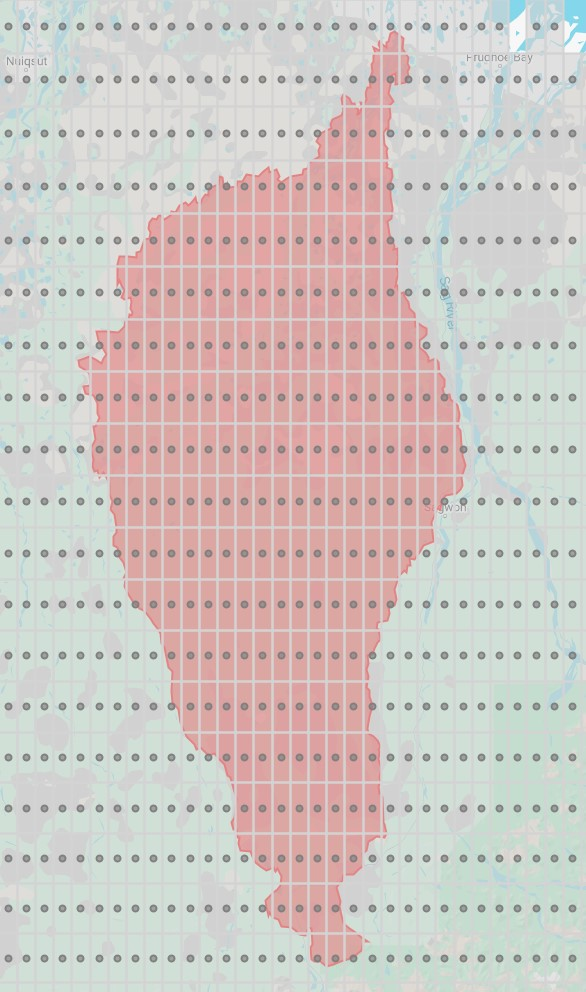

In [5]:
display(HTML(display_image_gh_notebook('3-kuparak-era5.jpg')))

In the following code block, we will intersect the Kuparuk gage's watershed with the ERA5-Land hourly polygons and sample met data from each intersecting polygon. I am going to jump the gun and show you here which polygons will be sampled.


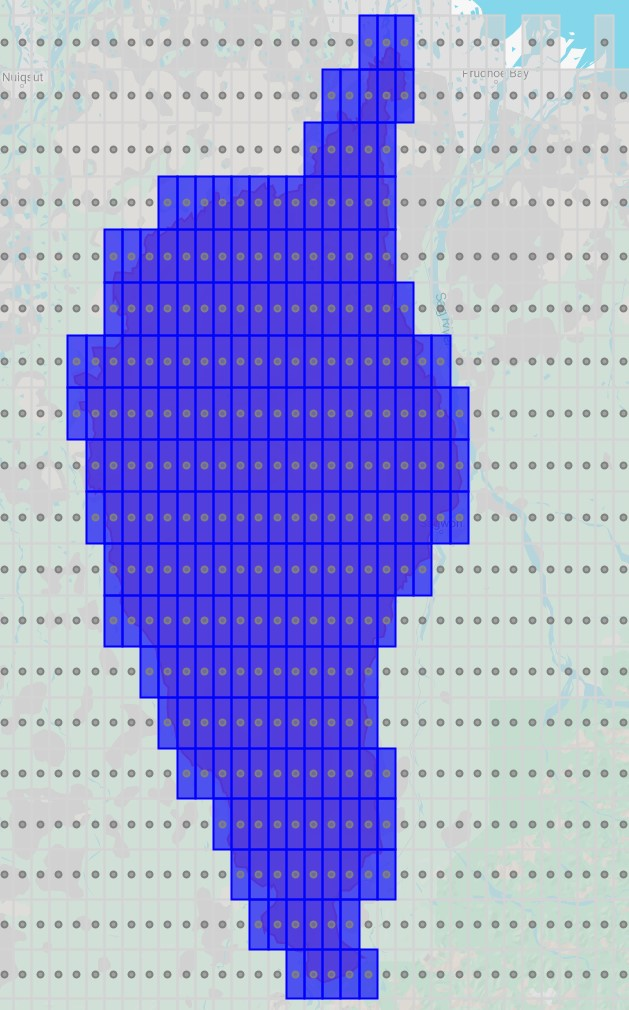

In [6]:
display(HTML(display_image_gh_notebook('3-kuparak-era5-intersecting.jpg')))

Ok, now we can get to the actual code. 

### Set up our request via a dictionary of parameters

Similar to notebook `2`, we will build a dictionary of `params` that we'll pass to the `sample_e5lh` function. There are a few new ones to take note of here.

- `geometries` : this is the same as before; you can provide a GeoDataFrame containing geometries you want to sample, or a string representing a path to a GEE Asset, or a ee.FeatureCollection() object. We'll do the last one in this example.
- `geometry_id_field` : this is a string that points to the unique ID field in the GeoDataFrame, Asset, or FeatureCollection. This is optional to provide, but if you don't provide it, `ngeegee` will try to figure out which column should be used. `ngeegee` is pretty dumb, so it's recommended you just specify this.

All other parameters were described in [Noteboook 2](https://github.com/NGEE-Arctic/NGEEGEE/blob/main/notebooks/2.%20Downloading%20ERA5-Land%20hourly%20met%20data%20across%20regions%20(polygons)%20and%20exporting%20to%20ELM.ipynb).

I've uploaded a shapefile of the Kuparuk to `ngeegee`'s data folder, so you should have it and the following code should just work.

In [ ]:
import ee
import pandas as pd
import geopandas as gpd
from ngeegee import utils
from ngeegee import e5l_utils as eu

# Make sure to Initialize with the correct project name (do not use mine--it won't work for you)
ee.Initialize(project='ee-jonschwenk')

# Load Kuparuk gage watershed polygon; convert to ee object
kup = gpd.read_file(utils._DATA_DIR / 'Kuparuk_gageshed.shp')
kup = kup.buffer(0) # A hack to "fix" invalid geometries--not needed here but just demonstrating
kup_pgon = ee.Geometry.Polygon(list(kup.geometry.values[0].exterior.coords))

# Point to the ERA5-Land hourly polygon grid
e5lh_grid = ee.FeatureCollection('projects/ee-jonschwenk/assets/E3SM/e5lh_grid') # already publicly shared

# Intersect and return the e5lh ids
intersecting_e5l_grids = e5lh_grid.filter(ee.Filter.intersects('.geo', kup_pgon))
pids = intersecting_e5l_grids.aggregate_array('pids').getInfo()

# Now we select the E5LH grid cells we want to sample
sample_these_cells = e5lh_grid.filter(ee.Filter.inList('pids', pids)) # This is an ee.FeatureCollection() object
print(f'You will be sampling over {len(pids)} geometries.')

params = {
    'start_date' : '1950-01-01', # YYYY-MM-DD
    'end_date' : '1957-01-01', # YYYY-MM-DD
    'geometries' : sample_these_cells, # Dictionary of {'name' : (lat, lon)} for all points to sample
    'geometry_id_field' : 'pids', # The e5lh_grid Asset calls this field "pids", so we must specify that
    'gee_bands' : 'elm', # Select ELM-required bands
    'gee_years_per_task' : 1, # Optional parameter; default is 5. For lots of points, you may want to reduce this for smaller GEE Tasks (but more of them)
    'gee_scale' : 'native',
    'gdrive_folder' : 'ngee_test_cells', # Which folder to store on your GDrive; will be created if not exists
    'job_name' : 'cell_test',
}
eu.sample_e5lh(params) 

You will be sampling over 245 geometries.
Your request will be executed as 7 Tasks in Google Earth Engine.
Export task submitted: cell_test_1950-01-01_1951-01-01
Export task submitted: cell_test_1951-01-01_1952-01-01
Export task submitted: cell_test_1952-01-01_1953-01-01
Export task submitted: cell_test_1953-01-01_1954-01-01
Export task submitted: cell_test_1954-01-01_1955-01-01
Export task submitted: cell_test_1955-01-01_1956-01-01
Export task submitted: cell_test_1956-01-01_1957-01-01


'All export tasks started. Check Google Drive or Task Status in the Javascript Editor for completion.'

## Now we wait.

We've fired off some jobs to GEE, and now we wait. For me, this took about 2-3 hours to fully export. You can wait if you want, but I've also just zipped all the `csv`s that will export from these jobs and uploaded them to [my GDrive](https://drive.google.com/drive/folders/1tKCroPzeaTT0K6SEbl9YtQtkuZYs90Gq?usp=sharing). You can just download this and unzip it and move on (but don't forget to kill your GEE Tasks).

## Now we continue.

Once you have the data (7 `csv` files) in a local directory, you can move on.

Similar to Notebook `2`, we will need to create a `df_loc` GeoDataFrame that is necessary for us to locate each geometry and ultimately create the netCDFs.

We then just specify some read/write paths and a few keyword arguments before calling `e5hl_to_elm_gridded`. Here I'll discuss some of the keyword arguments.

- `df_loc` : this needs to have `lon`, `lat`, and an id column (`pids` for us). If your geometries are irregular polygons, you probably want to use centroids. The lat/lon values you put here are what the met data will be referenced to in the exported netCDF.
- `remove_leap` : if `True`, this will remove leap days before exporting time series.
- `id_col` : similar to above, if you don't provide this, `ngeegee` will make a guess. Best practice is to just provide it.
- `nzones` : I am not 100% sure about this one, but according to Fengming, you might want to divide your ELM run into zones. He suggested that you'd use as many zones as you have processors to run on. The number of netCDFs that are exported will multiply by the number of zones you specify (e.g. 2 zones will export 14 files--7 variables x 2 zones). You can always re-run this with a different number of zones if you get something you're not expecting. More zones means smaller (but more) files.
- `compress` : If `True`, this will compress the netCDFs. I think generally you want to compress these files to save space, especiallly if computing on many geometries over long times.
- `compress_level` : can be set to 0-9, with higher numbers being more compression. More compression means it might take longer to export the files, but in my testing the difference between 4 and 9 was negligible.

That's it. The other thing you should be aware of is that the netCDFs are *packed* under the hood. This is essentialy rescaling the data so they can be stored as `int16` instead of `float`, saving space. The parameters (`add_offset` and `scale_factor`) of this packing are stored in each netCDF itself, and when the netCDF is loaded, it automatically *unpacks* the data. At least it does when I open datasets using `xarray`. You do not need to worry about this *packing* process, but you should be aware that it's happening.

In [13]:
# Create coordinate DataFrame
df_loc = pd.DataFrame({'pids' : pids,
          'lat' : [float(p.split(',')[0]) for p in pids],
          'lon' : [float(p.split(',')[1]) for p in pids]})

# Change this to point at your downloaded csvs!
csv_directory = r'X:\Research\NGEE Arctic\NGEEGEE\data\celltesting'

# Change this to point to where you want to save stuff!
write_directory = r'X:\Research\NGEE Arctic\NGEEGEE\data\celltesting\elm_formatted'

# Export the gridded netCDFs. Notice this command is the same as Notebook 2, but with "_gridded" appended.
eu.e5hl_to_elm_gridded(csv_directory, 
                       write_directory, 
                       df_loc, 
                       remove_leap=True, 
                       id_col='pids', 
                       nzones=1, 
                       compress=True,
                       compress_level=9
                       )

Processing file 1 of 7: cell_test_1950-01-01_1951-01-01.csv
Processing file 2 of 7: cell_test_1951-01-01_1952-01-01.csv
Processing file 3 of 7: cell_test_1952-01-01_1953-01-01.csv
Processing file 4 of 7: cell_test_1953-01-01_1954-01-01.csv
Processing file 5 of 7: cell_test_1954-01-01_1955-01-01.csv
Processing file 6 of 7: cell_test_1955-01-01_1956-01-01.csv
Processing file 7 of 7: cell_test_1956-01-01_1957-01-01.csv


And that's it!

## Some analysis of our exports

Here is a screenshot of my `write_directory` after running `e5hl_to_elm_gridded`:


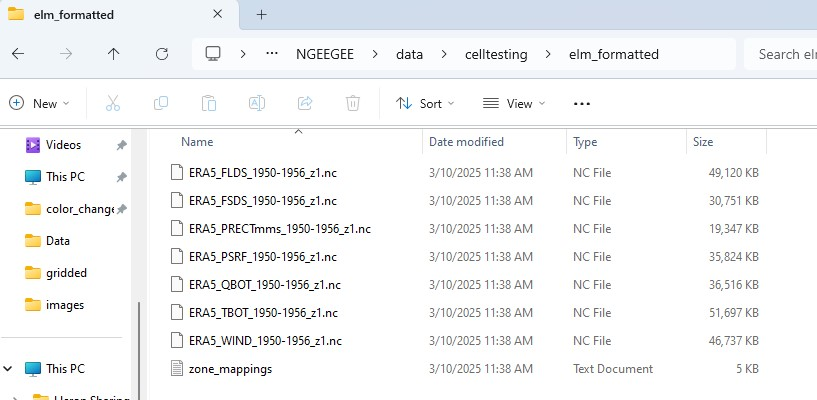

In [15]:
display(HTML(display_image_gh_notebook('3-export-proof.jpg')))

You can see that we have 7 met var files (good). Each has a different filesize on disk. This is expected as packing and compression are more/less effective depending on the data themselves. You also see a new file called `zone_mappings.txt`. This is needed for `OLMT` runs and is where zones are specified. If you specified more than 1 zone, you will see files that end with `zN` where `N` is the number of each zone. (Note that in Notebook 2 I thought that the `z` referred to the height above ground the observations were considered to be at, but that is wrong and I will fix it.)